In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

/home/nihang/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
##transform.ToTensor: convert image to numbers
##transform.Normalize: normalize the tensor with mean and std.
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [3]:
# download MNIST dataset
trainset = datasets.MNIST('./', download=True, train=True, transform=transform)
valset = datasets.MNIST('./', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

torch.Size([64, 1, 28, 28]) torch.Size([64])


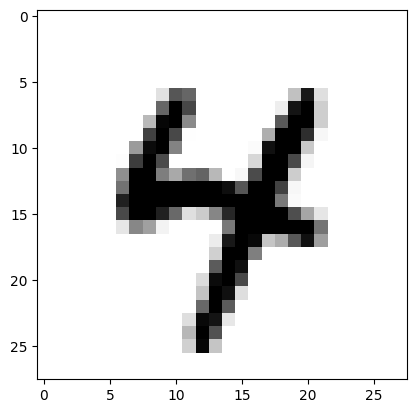

In [4]:
## 
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape, labels.shape)

## show an image
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

In [5]:
# ## display more images
# figure = plt.figure()
# num_of_images = 60
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [6]:
# ReLU
def relu(x):
    return np.maximum(0, x)

# Derivative of the relu 
def der_relu(x):
    return 1.0*(x>0)

In [7]:
## build the neural network with two hidden layers
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model.parameters())

<generator object Module.parameters at 0x7f2f93eae120>


In [8]:
for layer in model.parameters():
    print(layer.shape)

torch.Size([128, 784])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [9]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss


In [10]:
## training process
#optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
lr = 0.0008

train_list = []
valid_list = []

min_loss = np.inf
epochs = 500
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        #optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        with torch.no_grad():
            for param in model.parameters():
                param -= lr*param.grad

        #And optimizes its weights here
        #optimizer.step()
        
        running_loss += loss.item()
    
        model.zero_grad()
    #else:
    #    print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        
    ## valid each epoch
    correct_count, all_count = 0, 0
    valid_loss = 0
    with torch.no_grad():
        for images,labels in valloader:
            img = images.view(images.shape[0], -1)
            output = model(img)
            # print(output.shape)
            loss = criterion(output, labels)
            valid_loss += loss
            for i in range(len(labels)):
                img = images[i].view(1, 784)
                with torch.no_grad():
                    logps = model(img)
                ps = torch.exp(logps)
                probab = list(ps.numpy()[0])
                pred_label = probab.index(max(probab))
                true_label = labels.numpy()[i]
                if(true_label == pred_label):
                    correct_count += 1
                all_count += 1
    
    
    tmp_train_loss = running_loss/len(trainloader)
    tmp_valid_loss = valid_loss/len(valloader)
    
    train_list.append(tmp_train_loss)
    valid_list.append(tmp_valid_loss)
    
    if min_loss > tmp_valid_loss:
        bst_model = model
    if e%5 == 0: 
        print("Epoch {} - Training loss: {}, Valid loss: {}, valid accuracy: {}".format(e, tmp_train_loss, tmp_valid_loss, correct_count/all_count))
    # print("Number Of Images Tested =", all_count)
    #print("Valid Model Accuracy =", (correct_count/all_count))
    
    
print("Training Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 2.250600530902968, Valid loss: 2.1845455169677734, valid accuracy: 0.3172
Epoch 5 - Training loss: 0.8707033729375299, Valid loss: 0.7667863965034485, valid accuracy: 0.8127
Epoch 10 - Training loss: 0.4946035433933933, Valid loss: 0.4630560278892517, valid accuracy: 0.8745
Epoch 15 - Training loss: 0.4016501232981682, Valid loss: 0.38223323225975037, valid accuracy: 0.8928
Epoch 20 - Training loss: 0.35999391590163654, Valid loss: 0.34338465332984924, valid accuracy: 0.9026
Epoch 25 - Training loss: 0.3347539530316396, Valid loss: 0.3221394121646881, valid accuracy: 0.9063
Epoch 30 - Training loss: 0.3171451529190103, Valid loss: 0.30577144026756287, valid accuracy: 0.9112
Epoch 35 - Training loss: 0.3030662423909219, Valid loss: 0.2920578718185425, valid accuracy: 0.9167
Epoch 40 - Training loss: 0.2914284908933553, Valid loss: 0.2823936939239502, valid accuracy: 0.9196
Epoch 45 - Training loss: 0.2808937486539136, Valid loss: 0.2745712697505951, valid accura

Epoch 400 - Training loss: 0.05454065876681286, Valid loss: 0.08916892856359482, valid accuracy: 0.9719
Epoch 405 - Training loss: 0.0537037297066595, Valid loss: 0.08984105288982391, valid accuracy: 0.9727
Epoch 410 - Training loss: 0.05281362741458804, Valid loss: 0.08865058422088623, valid accuracy: 0.9723
Epoch 415 - Training loss: 0.05214938601758927, Valid loss: 0.08876809477806091, valid accuracy: 0.9728
Epoch 420 - Training loss: 0.0511502928680369, Valid loss: 0.08788720518350601, valid accuracy: 0.9725
Epoch 425 - Training loss: 0.05043139192424635, Valid loss: 0.08795351535081863, valid accuracy: 0.9728
Epoch 430 - Training loss: 0.049638301911039046, Valid loss: 0.08869679272174835, valid accuracy: 0.9723
Epoch 435 - Training loss: 0.048917424625782635, Valid loss: 0.0867656022310257, valid accuracy: 0.9727
Epoch 440 - Training loss: 0.048205944730826754, Valid loss: 0.08724566549062729, valid accuracy: 0.9727
Epoch 445 - Training loss: 0.04745398019688692, Valid loss: 0.08

In [13]:
# save best model
torch.save(bst_model, './my_mnist_model.pt') 

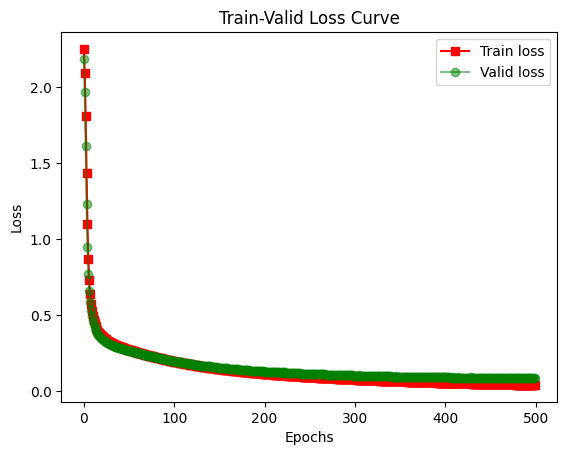

In [14]:
## plot loss cruve
import matplotlib.pyplot as plt

idx_list = list(range(len(valid_list)))

#fig = plt.figure()
plt.plot(idx_list,train_list,'s-',color = 'r',label="Train loss")  # train curve
plt.plot(idx_list,valid_list,'o-',color = 'g',label="Valid loss", alpha = 0.5)  # validation curve
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend() 
plt.title("Train-Valid Loss Curve")
plt.savefig("Q1_loss_curve")
plt.show()
